In this notebook the HGBR model is trained an the Figures 7 and 8 of the paper are created. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from utils import get_train_test, plot_preds 

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
## Histogram Gradient Boosting regression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import HistGradientBoostingRegressor

param = {"max_iter": [10, 20, 50, 100, 300, 500],
         "loss": ['loss','gamma','poisson', 'quantile'],
         # "l2_regularization":[0.0, 0.5, 1.0]
        }

cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [5]:
dict_label = {'sud': 'Southeast', 'ceo': 'Midwest', 'sul': 'South', 'ne':'Northeast', 'no':'North'} 


In [6]:
df = pd.read_csv('data/features_no.csv.gz', index_col = 'Unnamed: 0')

df.head()

,year,cases_jan,cases_3rdQ,cases_4thQ,population,peak_week_1,R0,t_end,ep_dur,dummy_ep,...,jan_temp_range,jan_max_temp,jan_min_temp,jan_tot_precip,rainy_days_jan,enso_jan,latitude,longitude,peak_week,geocode
0,2012,2.639057,3.555348,2.639057,10.159485,12.113873,1.422825,32,31,1,...,5.623635,29.420512,23.796876,91.433849,3.433987,-1.08,-0.983373,-62.9311,21.323685,1300409
1,2021,0.693147,3.871201,1.386294,10.226947,40.000000,1.349717,51,49,1,...,5.452601,29.505701,24.053100,76.506310,3.433987,-1.20,-0.983373,-62.9311,34.282435,1300409
2,2021,4.219508,2.302585,4.219508,10.690467,7.465931,2.199706,16,15,1,...,5.998800,28.921503,22.922703,124.760211,3.433987,-1.20,-4.377680,-70.0342,11.887917,1300607
3,2014,3.178054,4.574711,4.094345,10.547261,37.194264,1.237229,51,50,1,...,6.793901,30.204493,23.410592,93.780748,3.433987,-0.51,-4.391540,-59.5874,16.680013,1300805
4,2015,1.945910,2.890372,1.098612,10.563285,16.680013,1.567545,32,31,1,...,6.564921,29.524120,22.959199,131.857981,3.433987,0.23,-4.391540,-59.5874,30.169698,1300805


### train model

In [7]:
%%time 

i = 0
    
for region in ['no', 'sud', 'ne', 'ceo', 'sul']: 

    df =  pd.read_csv(f'data/features_{region}.csv.gz', index_col = 'Unnamed: 0')

    X_train, y_train, X_test, y_test = get_train_test(df, target = 'peak_week', test_year = 2024)
    
    sc_x = StandardScaler()
    
    sc_x.fit(X_train)
       
    X_train_ = sc_x.transform(X_train)
    X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)
    
    hgbm = HistGradientBoostingRegressor(l2_regularization = 0.2)
    
    grid_search = GridSearchCV(
            estimator=hgbm,
            param_grid=param,
            return_train_score=True,
            cv=cv,
        ).fit(X_train_, y_train)

    pred_tr = grid_search.best_estimator_.predict(X_train_)

    joblib.dump(grid_search.best_estimator_, f'saved_models/hist_gradient_boosting_reg_{region}.pkl')

    i = i+2


CPU times: user 3min 4s, sys: 4min 59s, total: 8min 3s
Wall time: 5min 55s


### Generate Figure 8

In [8]:
fig = plt.figure(figsize=(18, 10.5))
gs = gridspec.GridSpec(2, 6, figure=fig)

# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])


for ax, region in zip([ax1,ax2,ax3,ax4,ax5],['sul',  'sud', 'ceo', 'ne', 'no']):

    df =  pd.read_csv(f'data/features_{region}.csv.gz', index_col = 'Unnamed: 0')

    X_train, y_train, X_test, y_test = get_train_test(df, target = 'peak_week', test_year = 2024)
    
    sc_x = StandardScaler()
    
    sc_x.fit(X_train)
       
    X_train_ = sc_x.transform(X_train)
    X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)
    
    model = joblib.load(f'saved_models/hist_gradient_boosting_reg_{region}.pkl')

    pred_tr = model.predict(X_train_)

    dft_train = pd.DataFrame()
    
    dft_train['target'] = y_train

    dft_train['pred'] = pred_tr

    plot_preds(ax, dft_train, None, bounds = np.arange(min(dft_train['target']), max(dft_train['target'])))

    res = dft_train['target'] - dft_train['pred']

    m_train = f'''R2: {round(r2_score(dft_train['target'],dft_train['pred']), 2)} \nRMSE: { round(mse(dft_train['target'], dft_train['pred'] , squared = False),2)}'''

    ax.set_title(f"""{dict_label[region]}""") 

    at = AnchoredText(m_train,
                 prop=dict(size=10), frameon=True,
                  loc=4,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

    ax.add_artist(at)

plt.tight_layout()
plt.savefig(f'figures/hist_train_all.png', dpi = 600, bbox_inches = 'tight')

plt.close()

### compute the shap values and gen Figure 8

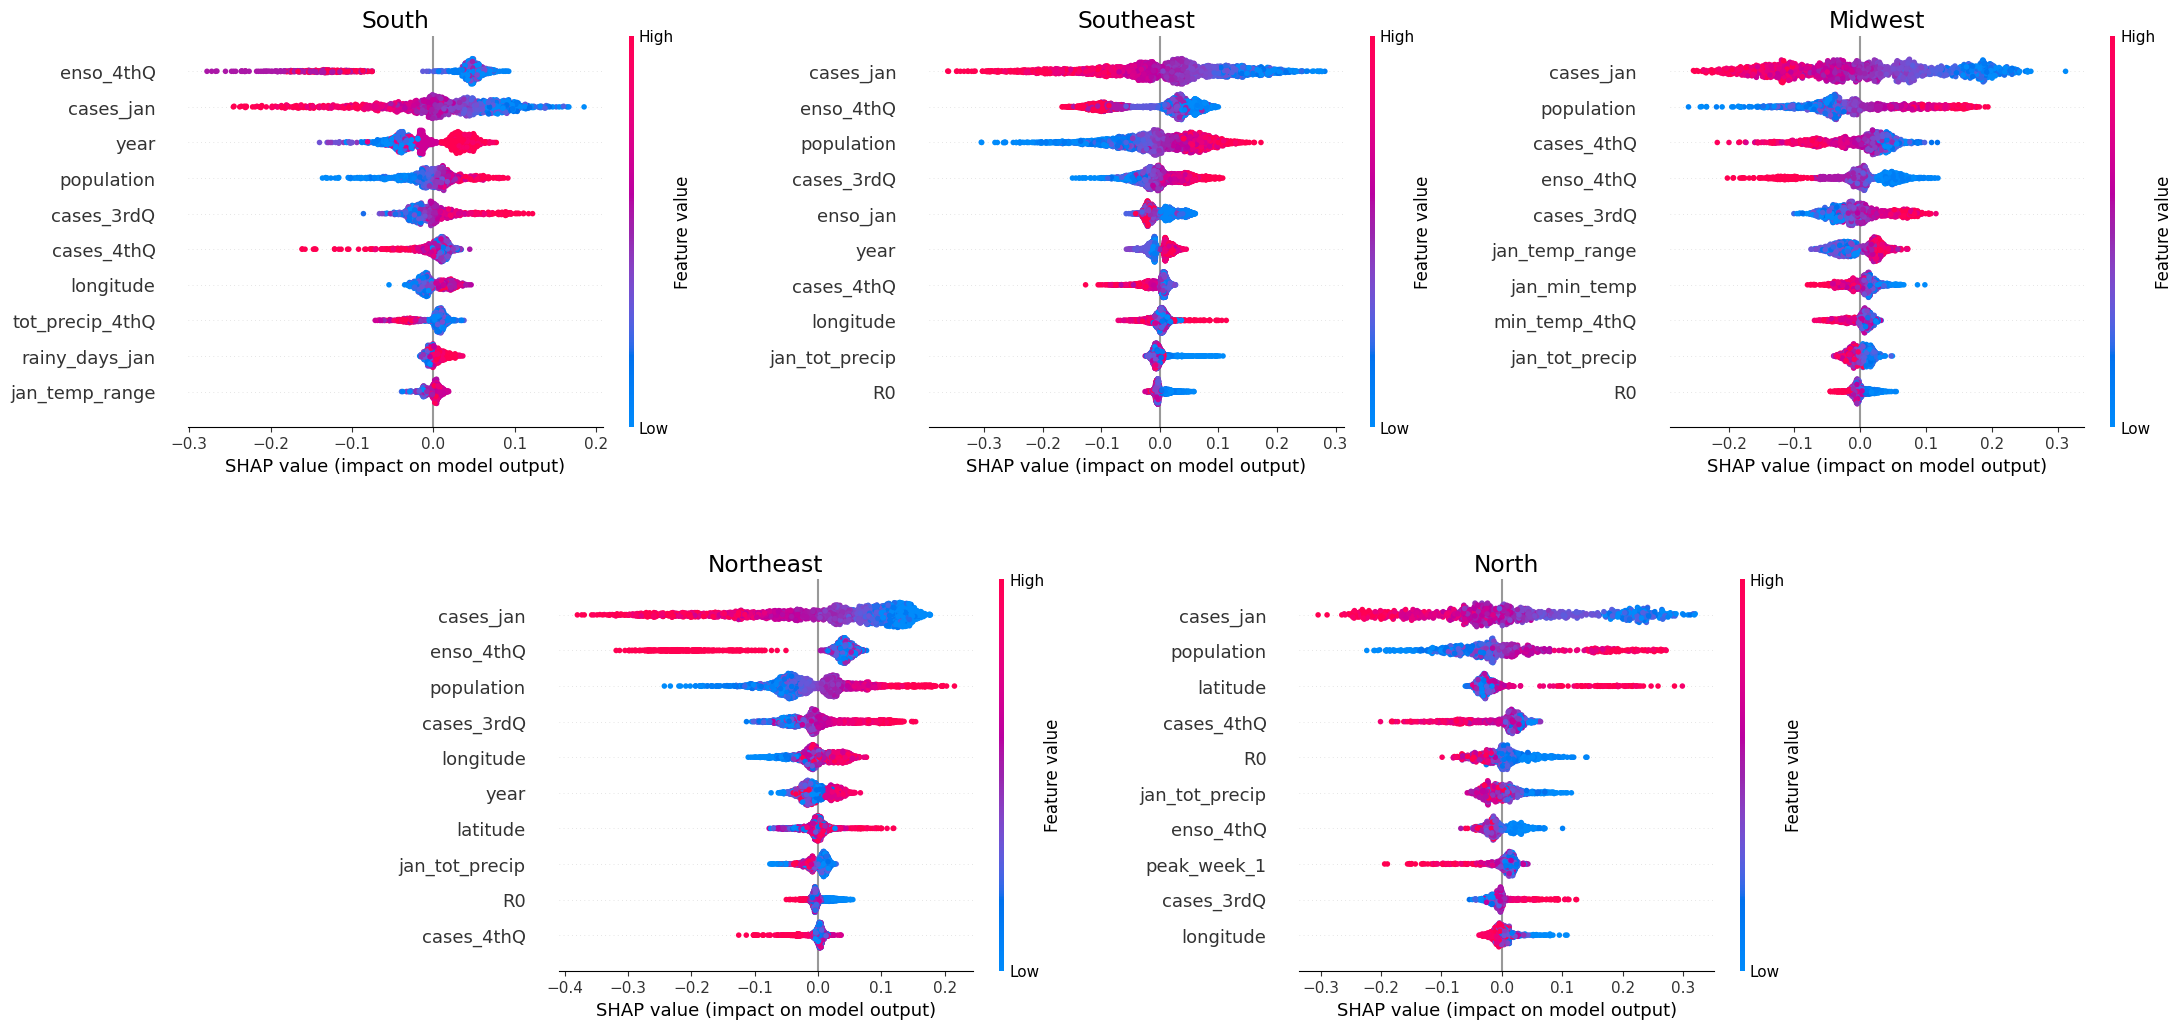

CPU times: user 11.1 s, sys: 179 ms, total: 11.3 s
Wall time: 7.49 s


In [9]:
%%time 
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(2, 6, figure=fig)

# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])


for ax, region in zip([ax1,ax2,ax3,ax4,ax5],['sul',  'sud', 'ceo', 'ne', 'no']):

    df =  pd.read_csv(f'data/features_{region}.csv.gz', index_col = 'Unnamed: 0')

    X_train, y_train, X_test, y_test = get_train_test(df, target = 'peak_week', test_year = 2024)
        
    sc_x = StandardScaler()
    
    sc_x.fit(X_train)
       
    X_train_ = sc_x.transform(X_train)
    X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)
    
    model = joblib.load(f'saved_models/hist_gradient_boosting_reg_{region}.pkl')

    explainer = shap.Explainer(model) 
    shap_values = explainer(X_train_)

    plt.sca(ax)
    shap.summary_plot(shap_values, X_train_, max_display = 10, show=False)
    
    ax.set_title(f"""{dict_label[region]}""")

plt.subplots_adjust(
    left=1.5,
    bottom=0.1, 
    right=4, 
    wspace = 1.5,
    top=1.8
)
plt.savefig(f'figures/hist_shap_all.png', dpi = 600, bbox_inches = 'tight')

plt.show()